### Importing libraries 


In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Path to store weights

In [3]:
path='/content/drive/My Drive/Colab Notebooks/weights3/'
dir_list = os.listdir(path) 
print(dir_list)

['signet-Engsig61-001.h5', 'signet-Engsig61-003.h5', 'signet-Engsig61-004.h5', 'signet-Engsig61-006.h5', 'signet-Engsig61-007.h5', 'signet-Engsig61-008.h5', 'signet-Engsig61-009.h5', 'signet-Engsig61-010.h5']


Path to dataset

In [4]:
path = r"/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset"

In [5]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()
dir_list

## Image Processing

In [ ]:
def preprocess(image):
    clean = remove_background(image)
    roi = extract_signature(clean)
    th,res= cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # r = ndimage.rotate(res, -(90-math.degrees(math.atan(res.shape[1]/res.shape[0]))))
    # angle = 90-math.degrees(math.atan(res.shape[1]/res.shape[0]))
    # if angle > 20:
    #     res = rotate_image(res, -(angle if angle>20 else 0))
   
    return res

def rotate_image(image, angle):
  rot_mat = cv2.getRotationMatrix2D((image.shape[0]/2+40,image.shape[1]/2+40), angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, (int(math.sqrt(image.shape[0]*image.shape[0]+image.shape[1]*image.shape[1])),int(image.shape[1])), flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result



def extract_signature(image):
    result = image.copy()
    img = image.copy()
    ret, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    cnts,hi = cv2.findContours(closing.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])
    
    boxes = np.asarray(boxes)
    left = np.min(boxes[:,0])
    top = np.min(boxes[:,1])
    right = np.max(boxes[:,2])
    bottom = np.max(boxes[:,3])
    
    result[closing==0] = (255)
    ROI = result[top:bottom, left:right].copy()
    cv2.rectangle(result, (left,top), (right,bottom), (36, 255, 12), 2)
    
    # cv2.imshow('result', result)
    # cv2.imshow('ROI', ROI)
    # cv2.imshow('Mask', mask)
    # cv2.imshow('closing',closing)

    cv2.waitKey()
    
    return ROI


def remove_background(img):
        """ Remove noise using OTSU's method.

        :param img: The image to be processed
        :return: The normalized image
        """
        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
    
        threshold, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img

## Forged Groups from cedar dataset

In [7]:
forg_groups = []
for i in dir_list[0]:
    images = os.listdir(path+'/'+dir_list[0])
    images.sort()

    images = [path+'/'+ dir_list[0] + '/'+ x for x in images]

print(len(images))
i=0
j=12
for _ in range(0,61):#57    
    forg_groups.append(images[i:j])
    i=j
    j+=12
forg_groups[60]

1320


['/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_1.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_10.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_11.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_12.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_13.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_14.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_15.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_16.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_17.png',
 '/content/drive/My Drive/Colab Notebooks/datasets/cedar_dataset/full_forg/forgeries_38_18.png',
 '/content/drive/My Drive/Colab

## Original Groups from cedar dataset

In [ ]:
orig_groups= []
for i in dir_list[0]:
    images = os.listdir(path+'/'+dir_list[1])
    images.sort()
    # images.remove('Thumbs.db')
    images = [path+'/'+ dir_list[1] + '/'+ x for x in images]

print(len(images))
i=0
j=12
for _ in range(0,61):    
    orig_groups.append(images[i:j])
    i=j
    j+=12
orig_groups[60]

In [9]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [11]:
# Quick check to confirm that there are 12 Genuine signatures for each individual
flag=0
for i in range(0,len(orig_lengths)):
	for j in range(i+1,len(orig_lengths)):
		       if orig_lengths[i]==orig_lengths[j]:
			       flag=1
print(flag)

1


In [13]:
# Quick check to confirm that there are 12 Forged signatures for each individual
flag=0
for i in range(0,len(forg_lengths)):
	for j in range(i+1,len(forg_lengths)):
		       if forg_lengths[i]==forg_lengths[j]:
			       flag=1
print(flag)

1


## Train-Validation-Test Split
* Signatures of 40 people are used for training
* Signatures of 15 people are used for validation
* Signatures of 06 people are used for testing

In [10]:
#orig_train, orig_val, orig_test = orig_groups[:1224], orig_groups[1224:], orig_groups[1320:]
#forg_train, forg_val, forg_test = forg_groups[:1224], forg_groups[1224:], forg_groups[1320:]
#orig_train, orig_val, orig_test = orig_groups[:1176], orig_groups[1200:1320], orig_groups[1320:]
#forg_train, forg_val, forg_test = forg_groups[:1176], forg_groups[1200:1320], forg_groups[1320:]

orig_train, orig_val, orig_test = orig_groups[:40], orig_groups[40:55], orig_groups[55:]
forg_train, forg_val, forg_test = forg_groups[:40], forg_groups[40:55], forg_groups[55:]

## Generating batch 

In [11]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [12]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        

        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 6)))) #6 for 6 samples random
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            # img1 = preprocess(img1)
            # img2 = preprocess(img2)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

## Similairity Metric and Loss Function

In [13]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [14]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

## Network Architecture

In [18]:
def network_architecture(input_shape):

    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))

    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))    
    model.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    
    model.add(Flatten(name='flatten'))

    model.add(Dense(1024, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return model

In [19]:
input_shape=(img_h, img_w, 1)

In [20]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [37]:
base_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 37, 53, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 53, 96)        148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 26, 96)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 22, 30, 96)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 18, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 26, 256)       72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 12, 256)        0

In [21]:
batch_sz = 128
#num_train_samples = 276*40 + 288*40
#num_val_samples = num_test_samples = 276*10 + 288*10
#num_train_samples = 276*40 + 288*40
#num_val_samples = num_test_samples = 276*15 + 288*6
#num_train_samples, num_val_samples, num_test_samples

num_train_samples = 66*40 + 72*40
num_val_samples = 66*15 
num_test_samples = 72*6
num_train_samples, num_val_samples, num_test_samples

(5520, 990, 432)

## Model Training

In [22]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=['acc'])

In [23]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/weights3/signet-Engsig61-{epoch:03d}.h5', monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=True,mode='min')
] #260-{epoch:03d}

In [43]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 20,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/20
43/43 [==============================] - 317s 7s/step - loss: 13.2334 - acc: 0.4789 - val_loss: 0.5049 - val_acc: 0.5190

Epoch 00001: val_loss improved from inf to 0.50490, saving model to /content/drive/My Drive/Colab Notebooks/weights3/signet-Engsig61-001.h5
Epoch 2/20
43/43 [==============================] - 63s 1s/step - loss: 0.2574 - acc: 0.4619 - val_loss: 0.5071 - val_acc: 0.5234

Epoch 00002: val_loss did not improve from 0.50490
Epoch 3/20
43/43 [==============================] - 59s 1s/step - loss: 0.2720 - acc: 0.4630 - val_loss: 0.5047 - val_acc: 0.5312

Epoch 00003: val_loss improved from 0.50490 to 0.50466, saving model to /content/drive/My Drive/Colab Notebooks/weights3/signet-Engsig61-003.h5
Epoch 4/20
43/43 [==============================] - 58s 1s/step - loss: 0.2603 - acc: 0.4551 - val_loss: 0.4974 - val_acc: 0.5167

Epoch 00004: val_loss improved from 0.50466 to 0.49739, saving model to /content/drive/My Drive/Colab Notebooks/weights3/signet-Engsig61-00

KeyboardInterrupt: ignored

# Testing

In [47]:
tpr_list = []
tnr_list = []
threshold_list = []

def compute_accuracy_roc(predictions, labels):
    '''Compute accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        tpr_list.append(tpr)
        tnr_list.append(tnr)
        threshold_list.append(best_thresh)
           
    return max_acc, best_thresh

### Loading the weights

In [25]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/weights3/signet-Engsig61-006.h5')

In [26]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], [] #tr_y have label
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [48]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.8734673754608592, 0.012809165744110942)

### Precision Recall and F-score

In [34]:
pred_binary = [1 if x<0.012809 else 0 for x in pred]

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(pred_binary, tr_y,average='macro')
precision,recall,fscore

(0.8734673754608592, 0.8835046554115031, 0.8719379092893524)

### Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

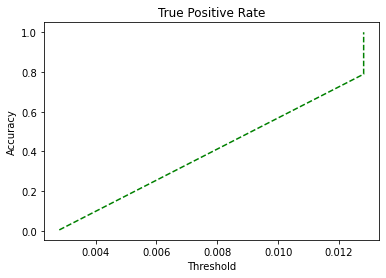

In [63]:
plt.plot(threshold_list,tpr_list,'g--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('True Positive Rate')

from google.colab import files
plt.savefig("TPR.png")
files.download("TPR.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

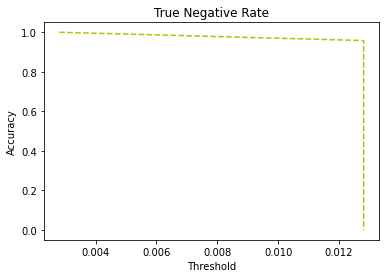

In [64]:
plt.plot(threshold_list,tnr_list,'y--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('True Negative Rate')

from google.colab import files
plt.savefig("TNR.png")
files.download("TNR.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

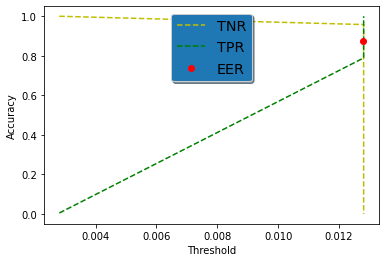

In [67]:
fig, ax = plt.subplots()

ax.plot(threshold_list, tnr_list, 'y--', label='TNR')
ax.plot(threshold_list, tpr_list, 'g--', label='TPR')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.plot(0.0128,tr_acc,'ro', label='EER') 

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

from google.colab import files
plt.savefig("EER.png")
files.download("EER.png") 

#### Accuracy = 87.34% and Threshold = 0.0128 



In [28]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    #print(img1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

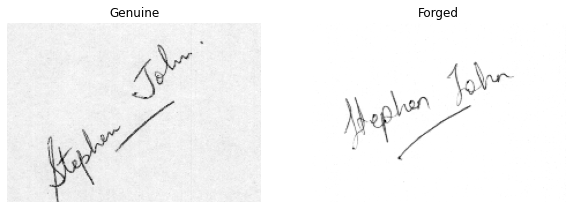

Difference Score =  0.027528115
Its a Forged Signature


In [31]:
predict_score()

### Saving Model Architecture for further use.

In [68]:
model_json=model.to_json()

In [70]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [72]:
siamese_json=base_network.to_json()
with open("siamese_BaseNetwork.json","w") as json_file:
    json_file.write(siamese_json)


In [73]:
from google.colab import files
files.download("model.json") 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
files.download('siamese_BaseNetwork.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>